In [1]:
import os
import shutil
from collections import defaultdict
from collections.abc import Callable
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import AEIC.trajectories.builders as tb
from AEIC.config import Config, config
from AEIC.missions import CountQuery, Database, Filter, Mission, Query
from AEIC.performance_model import PerformanceModel
from AEIC.trajectories import TrajectoryStore
from AEIC.trajectories.ground_track import GroundTrack

### Introduction

The idea here is:

1. Demonstrate running trajectory simulations based on missions taken from OAG data that has ingested into a missions database;
2. Save the simulation results to NetCDF files;
3. Perform subset queries on the mission database and retrieve the corresponding trajectories to calculate some (not very realistic) statistics.

The use case is silly and the mission database is the small one used for the test suite, but it should hopefully serve as some sort of inspiration!

### Setup

Set the AEIC path to include the main data directory and the test data directory (which includes the mission database) and load the default AEIC configuration.

In [2]:
os.environ['AEIC_PATH'] = ':'.join(
    str(Path.cwd().parent / d) for d in ['data', 'tests/data']
)
Config.load();

Load single performance model to use for all simulations.

In [3]:
perf = PerformanceModel(config.file_location('IO/sample_performance_model.toml'))

Select mission database (we just use a small test database here).

In [4]:
mission_db_file = config.file_location('missions/oag-2019-test-subset.sqlite')

Function to set up legacy trajectory builders to simulate flights. We use a function here so that we can create these things on demand in the worker function below. We disable the mass iteration because it causes lots of exceptions due to non-convergence. (I think they just used to be warnings, but they were happening so often that I think they need some attention, so I made them exceptions.)

In [5]:
def builder_maker():
    return tb.LegacyBuilder(options=tb.Options(iterate_mass=False))

### Trajectory simulation code

The code here simulates all missions in a mission database using a single performance model and saves the results to a trajectory store. The trajectories are simulated in parallel using a process pool.

Note how we use `with` everywhere for both the trajectory store and the mission database to ensure prompt cleanup!

First, the outer driver function:

In [6]:
def simulate_all(
    mission_db_file: str,
    output_store: str,
    perf: PerformanceModel,
    builder_maker: Callable[[], tb.Builder],
    n_jobs: int = 8,
):
    # Count flights to be simulated. We do this once to decide how many
    # flights to allocate to each worker process.
    with Database(mission_db_file) as db:
        nflights = db(CountQuery())
    print(f'Flights to process: {nflights}')

    # Limit and offset values to use in each worker job. These are used
    # directly in the LIMIT and OFFSET clauses in an SQL query. This splits
    # the query results into more or less equally sized groups.
    limits = [round(nflights / n_jobs)] * (n_jobs - 1)
    limits.append(nflights - sum(limits))
    offsets = [round(nflights / n_jobs) * job for job in range(n_jobs)]

    # Run slices of the database query result set in a process worker pool.
    print('Running slices of size:', ', '.join([str(lim) for lim in limits]))
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        # This pattern, of making a dictionary whose keys are futures running
        # the process pool and whose values are some identifier for each
        # slice, is a common one when using concurrent.futures.
        futures = {
            pool.submit(simulate_slice, idx, limit, offset, builder_maker): idx
            for idx, limit, offset in zip(range(1, n_jobs + 1), limits, offsets)
        }

        # Retrieve diagnostic results from futures as they complete and print
        # some messages.
        total_failed = 0
        slice_files = []
        print('')
        for future in as_completed(futures):
            slice_idx = futures[future]
            slice_file, nfailed, exceptions = future.result()
            total_failed += nfailed
            slice_files.append(slice_file)
            print(f'SLICE {slice_idx} COMPLETED ({nfailed} SIMULATIONS FAILED)')
            for exc in exceptions:
                print(exc)
        print('')
        print(f'Total failed simulations: {total_failed}')

    # Merge NetCDF files into single trajectory store.
    print('')
    print(f'Merging stores => {output_store}')
    TrajectoryStore.merge(output_store, slice_files)

And now the function that runs the simulations for a single slice.

In [7]:
def simulate_slice(
    slice_idx: int, limit: int, offset: int, builder_maker: Callable[[], tb.Builder]
):
    # There is one output file per slice. We'll merge them into a merged
    # trajectory store when we're done.
    output_file = f'slice-{slice_idx}.nc'
    if os.path.exists(output_file):
        os.remove(output_file)

    with TrajectoryStore.create(base_file=output_file) as ts:
        with Database(mission_db_file) as db:
            # Record failure information for return value.
            nfailed = 0
            exceptions = []

            # Report exceptions along with some mission information.
            def report(exc, mis):
                nonlocal exceptions
                exceptions.append(
                    f'{exc}: {mis.origin} -> {mis.destination} = '
                    f'{mis.gc_distance / 1000:0.2f} km'
                )

            # For short missions, the legacy trajectory builder tries to step
            # beyond the great circle distance between the origin and
            # destination points. We keep track of (origin, destination) pairs
            # here to avoid reporting repeated problems like this.
            short: set[tuple[str, str]] = set()

            # Create a trajectory builder.
            builder = builder_maker()

            # Retrieve all flights in this slice and simulate them one by one.
            for flight in db(Query(limit=limit, offset=offset)):
                # Create a mission from the flight database result. (We fix
                # the load factor here.)
                mission = Mission.from_query_result(flight, load_factor=1.0)

                # Fly the mission, catching exceptions.
                try:
                    traj = builder.fly(perf, mission)
                except ValueError as exc:
                    # General exception from trajectory builder.
                    report(exc, mission)
                    nfailed += 1
                    continue
                except GroundTrack.Exception as exc:
                    # Exception from ground track interpolator: usually
                    # because the builder has tried to step beyond the end of
                    # the great circle track between the origin and destination
                    # (this happens for very short flights).
                    if (mission.origin, mission.destination) not in short:
                        short.add((mission.origin, mission.destination))
                        report(exc, mission)
                    nfailed += 1
                    continue

                # Save the trajectory.
                ts.add(traj)

            # Return information passed back through the process pool future.
            return output_file, nfailed, exceptions

### Run simulations

Run all simulations from the mission database.

In [8]:
output_store = 'test-simulations.aeic-store'

In [9]:
shutil.rmtree(output_store, ignore_errors=True)
simulate_all(mission_db_file, output_store, perf, builder_maker)

Flights to process: 1197
Running slices of size: 150, 150, 150, 150, 150, 150, 150, 147

SLICE 1 COMPLETED (9 SIMULATIONS FAILED)
distance outside ground track range: DEN -> COS = 117.25 km
distance outside ground track range: HID -> KUG = 40.52 km
Aircraft is trying to fly below minimum mass: IAH -> DXB = 13144.49 km
distance outside ground track range: YUL -> YOW = 151.74 km
Aircraft is trying to fly below minimum mass: HAN -> CDG = 9172.62 km
distance outside ground track range: SEZ -> PRI = 43.55 km
distance outside ground track range: MCM -> NCE = 18.06 km
distance outside ground track range: BZE -> SPR = 54.37 km
Aircraft is trying to fly below minimum mass: JFK -> HND = 10899.16 km
SLICE 8 COMPLETED (10 SIMULATIONS FAILED)
distance outside ground track range: CGI -> PAH = 73.12 km
distance outside ground track range: YYJ -> YVR = 63.37 km
distance outside ground track range: HNL -> OGG = 162.01 km
distance outside ground track range: TFN -> VDE = 168.90 km
Aircraft is trying to 

### Statistics calculation

Let's answer a very artificial question: What's the proportion of time spent at different flight levels for flights by A320s?

How many such flights are there anyway?

Let's define the filter condition we want to use, so that we can change it easily to ask the same sort of question for other flight subsets:

In [10]:
flight_filter = Filter(aircraft_type='320')

Then count the flights:

In [11]:
with Database(mission_db_file) as db:
    print(db(CountQuery(flight_filter)))

238


And how many trajectory points for those flights do we have stored in our trajectory store?

In [12]:
with Database(mission_db_file) as db:
    with TrajectoryStore.open(base_file=output_store) as ts:
        npoints = 0
        for flight in db(Query(flight_filter)):
            traj = ts.get_flight(flight.id)
            if traj is None:
                print(f'MISSING: {flight.id}')
                continue
            npoints += len(traj)

In [13]:
npoints

72114

Now let's answer our silly question:

In [14]:
# This is a map from flight level to total times.
times = defaultdict(int)

with Database(mission_db_file) as db:
    with TrajectoryStore.open(base_file=output_store) as ts:
        for flight in db(Query(flight_filter)):
            # Look up the trajectory in the trajectory store by the flight ID
            # from the mission database.
            traj = ts.get_flight(flight.id)

            # For each step between waypoints, find the time interval and
            # mean flight level roundest to the nearest integer value.
            dts = traj.flight_time[1:] - traj.flight_time[:-1]
            fls = np.round((traj.flight_level[1:] + traj.flight_level[:-1]) / 2)

            # Add the times to the histogram data, converting to Python types
            # because Numpy types are annoying...
            for fl, dt in zip(fls, dts):
                times[int(fl)] += float(dt)

Sort the time values by flight level and plot (the `*zip(*...)` nonsense is just a Pythonic way to turn a list of tuples into a pair of list arguments).

<BarContainer object of 310 artists>

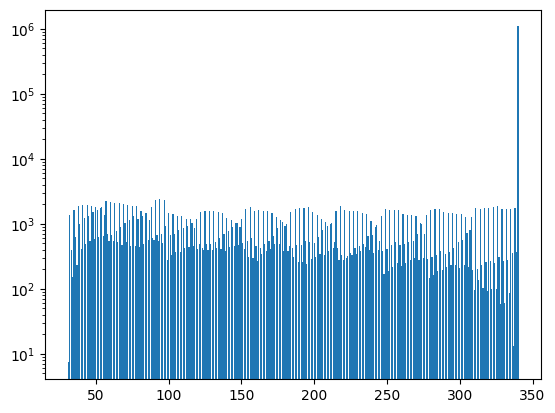

In [15]:
times_sorted = sorted(times.items())
plt.bar(*zip(*times_sorted), log='y')

Well, that's sure a big surprise.